In [1]:
import requests
import zipfile
import pandas as pd
from io import BytesIO

url = 'https://github.com/DataScienceAndEngineering/machine-learning-dse-i210-final-project-nyc-car-accident-severity/blob/main/data/processed/Processed_Data_v2.zip?raw=true'

# Download the zip file
response = requests.get(url)
zip_content = BytesIO(response.content)

# Unzip the file
with zipfile.ZipFile(zip_content, 'r') as zip_ref:
    # Extract all the contents into the current directory
    zip_ref.extractall()

    csv_filename = zip_ref.namelist()[0]

    # Read the CSV file
    mvc_processed = pd.read_csv(csv_filename)

In [2]:
# Combine Class 1, 2, 3 to make a  binary class dataset

mvc_processed_binary = mvc_processed

# Display original class distribution
print("Original Class Distribution:")
print(mvc_processed_binary['CLASS TYPE'].value_counts())

# Function to combine classes
def combine_classes(label):
    if label == 'Class 0':
        return 'Class 0'
    else:
        return 'Class 1'

# Apply the function to the 'CLASS TYPE' column
mvc_processed_binary['CLASS TYPE'] = mvc_processed_binary['CLASS TYPE'].apply(combine_classes)

# Display new class distribution
print("\nNew Class Distribution:")
print(mvc_processed_binary['CLASS TYPE'].value_counts())

Original Class Distribution:
CLASS TYPE
Class 0    824193
Class 1    231289
Class 2      1030
Class 3       905
Name: count, dtype: int64

New Class Distribution:
CLASS TYPE
Class 0    824193
Class 1    233224
Name: count, dtype: int64


In [3]:
# Convert CRASH DATE and CRASH TIME to datetime
mvc_processed_binary['CRASH DATE'] = pd.to_datetime(mvc_processed_binary['CRASH DATE'])

mvc_processed_binary['CRASH TIME'] = pd.to_datetime(mvc_processed_binary['CRASH TIME'], format='%H:%M:%S').dt.time

In [4]:
# Decompose date and time

mvc_processed_binary['year'] = mvc_processed_binary['CRASH DATE'].dt.year
mvc_processed_binary['month'] = mvc_processed_binary['CRASH DATE'].dt.month
mvc_processed_binary['day'] = mvc_processed_binary['CRASH DATE'].dt.day
mvc_processed_binary['dayofweek'] = mvc_processed_binary['CRASH DATE'].dt.dayofweek  # Monday=0, Sunday=6

# For time, since dt accessor doesn't work directly with dtype 'time', you need to convert them again to datetime:
mvc_processed_binary['temp_datetime'] = pd.to_datetime(mvc_processed_binary['CRASH TIME'].astype(str))

mvc_processed_binary['hour'] = mvc_processed_binary['temp_datetime'].dt.hour
mvc_processed_binary['minute'] = mvc_processed_binary['temp_datetime'].dt.minute
mvc_processed_binary['second'] = mvc_processed_binary['temp_datetime'].dt.second

# Drop the temporary datetime column used for extracting time
mvc_processed_binary.drop(['temp_datetime', 'CRASH DATE', 'CRASH TIME', 'second'], axis=1, inplace=True)

<ipython-input-4-12be95a482e1>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mvc_processed_binary['temp_datetime'] = pd.to_datetime(mvc_processed_binary['CRASH TIME'].astype(str))


In [5]:
mvc_processed_binary.head()

,LATITUDE,LONGITUDE,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CLASS TYPE,year,month,day,dayofweek,hour,minute
0,40.667202,-73.866500,Unspecified,No factor,No factor,No factor,No factor,Sedan,No vehicle,No vehicle,No vehicle,No vehicle,Class 0,2021,9,11,5,9,35
1,40.868160,-73.831480,Unspecified,Unspecified,No factor,No factor,No factor,Sedan,Sedan,No vehicle,No vehicle,No vehicle,Class 1,2021,12,14,1,8,17
2,40.751440,-73.973970,Passing Too Closely,Unspecified,No factor,No factor,No factor,Sedan,Station Wagon/Sport Utility Vehicle,No vehicle,No vehicle,No vehicle,Class 0,2021,12,14,1,14,58
3,40.675884,-73.755770,Turning Improperly,Unspecified,No factor,No factor,No factor,Sedan,Station Wagon/Sport Utility Vehicle,No vehicle,No vehicle,No vehicle,Class 0,2021,12,14,1,16,50
4,40.872620,-73.904686,Unspecified,Unspecified,No factor,No factor,No factor,Station Wagon/Sport Utility Vehicle,Sedan,No vehicle,No vehicle,No vehicle,Class 1,2021,12,11,5,19,43


In [6]:
# Encode the features and targets

from sklearn.preprocessing import LabelEncoder

# Create features set
X = mvc_processed_binary.drop('CLASS TYPE', axis=1)
y = mvc_processed_binary['CLASS TYPE']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Encode categorical variables
X_encoded = pd.get_dummies(X)

In [7]:
# Split data into trianing and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, stratify=y, test_size=0.2, random_state=42)

In [8]:
# Scale the features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Original Method

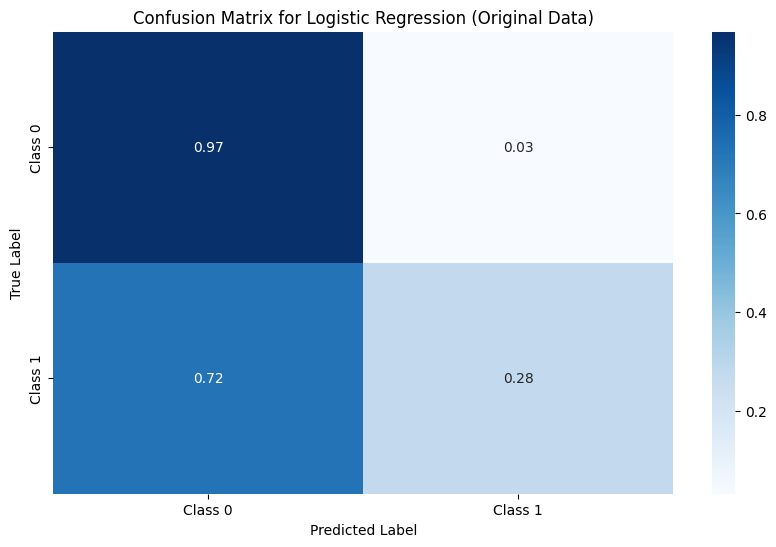

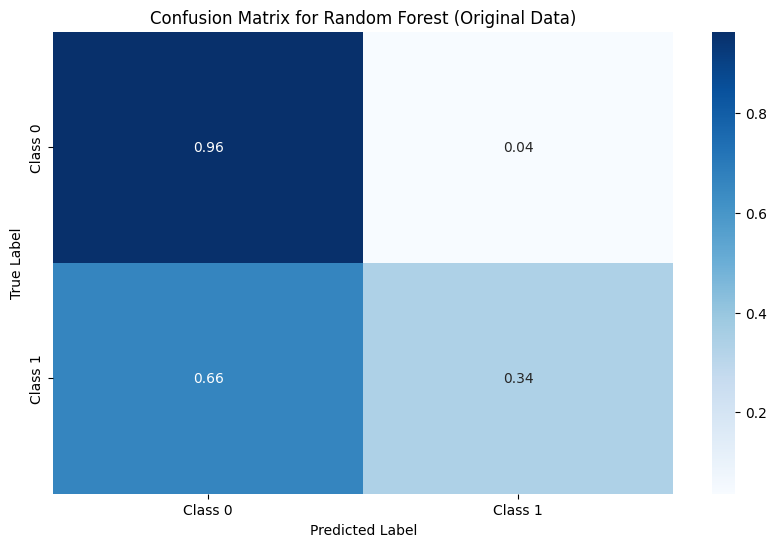

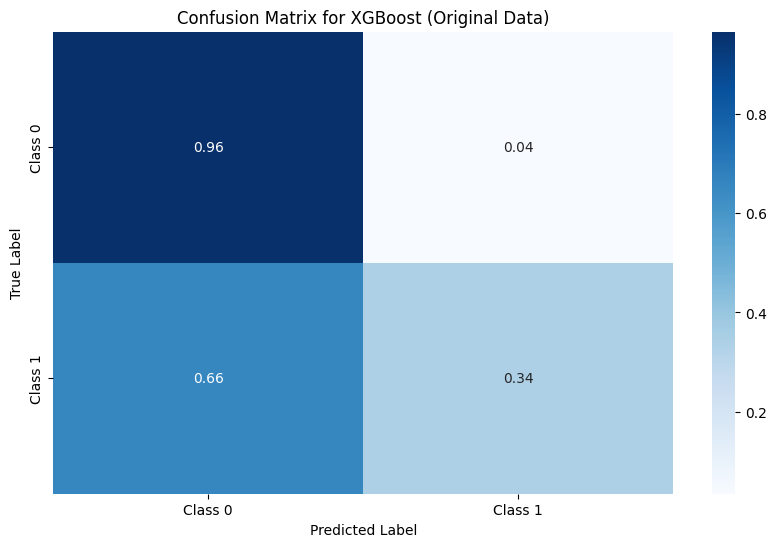

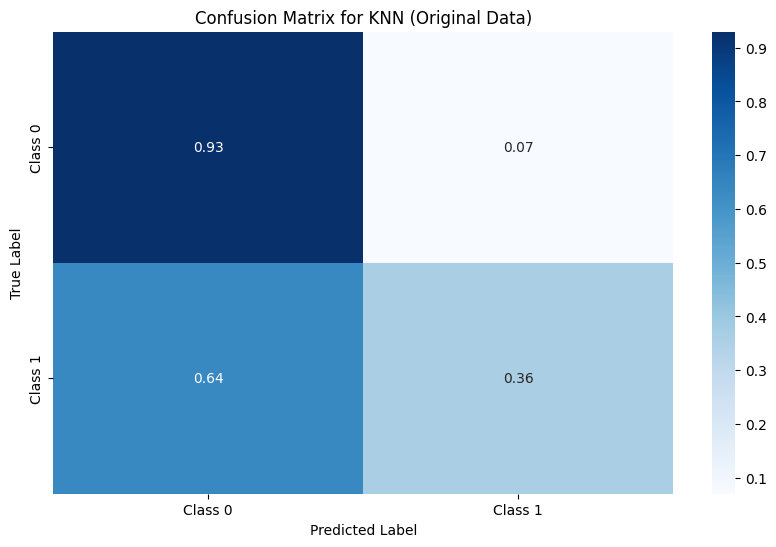

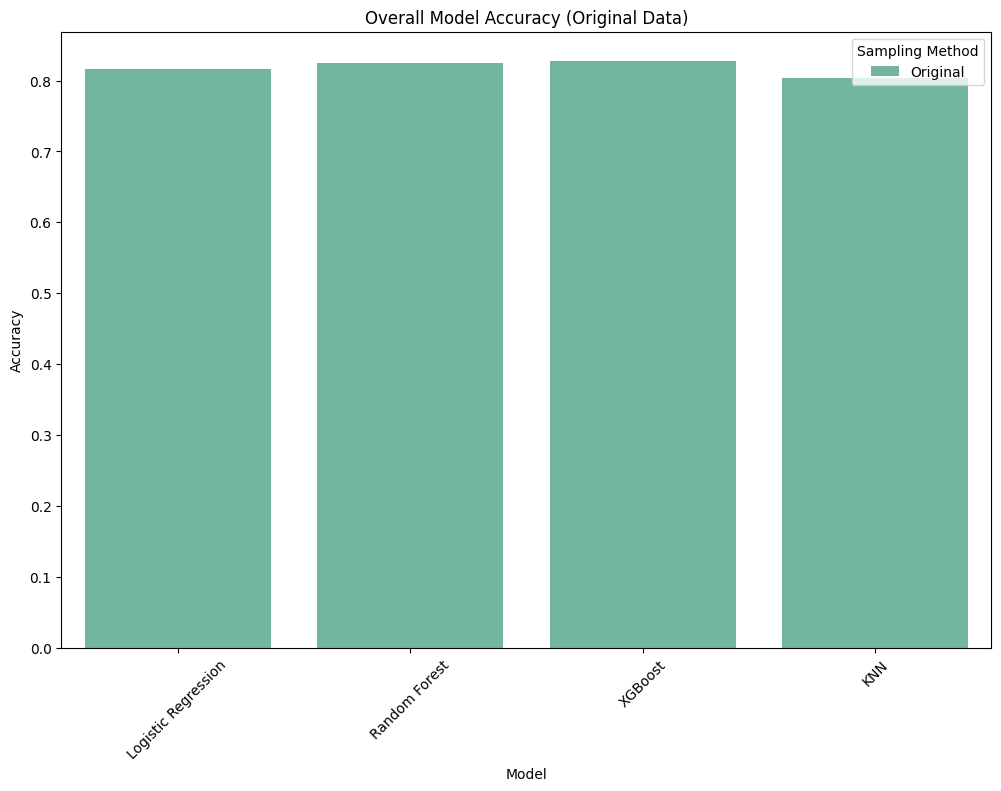

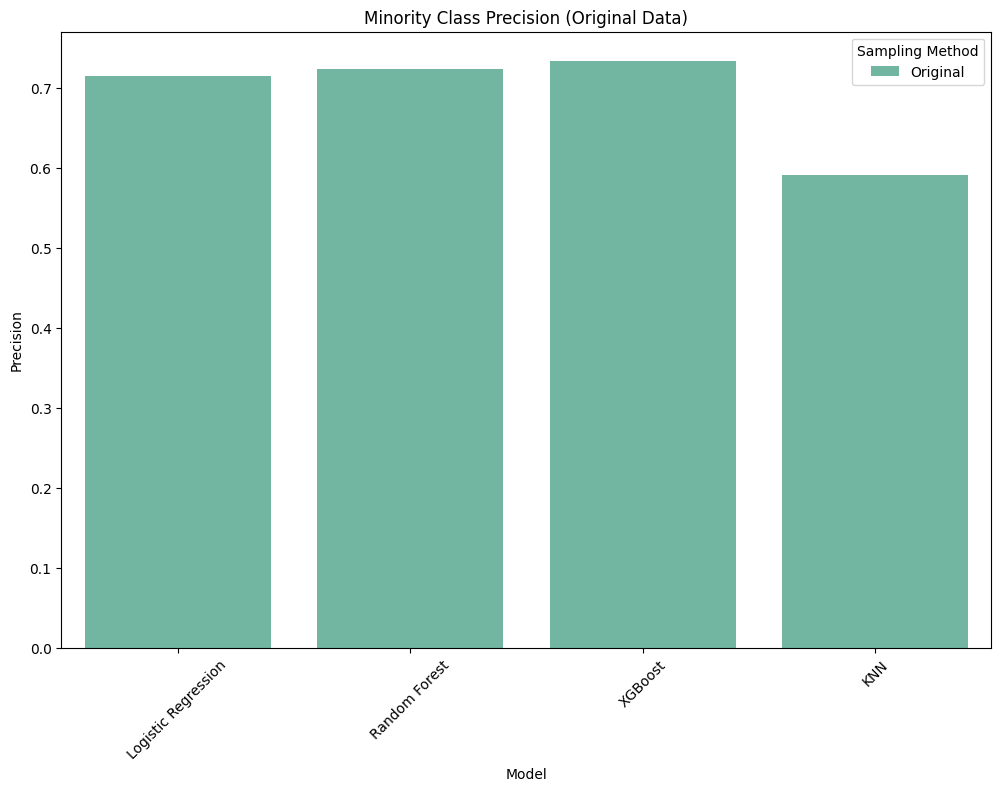

                 Model  Accuracy  Minority Precision  Minority Recall  \
0  Logistic Regression  0.815858            0.714230         0.275249   
1        Random Forest  0.825453            0.723876         0.337271   
2              XGBoost  0.827448            0.733306         0.342073   
3                  KNN  0.803834            0.591010         0.359117   

   Minority F1 Sampling Method  
0     0.397363        Original  
1     0.460148        Original  
2     0.466522        Original  
3     0.446765        Original  


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_jobs=-1)
}

# Initialize a list to store results
results_list = []

# Evaluate each model
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    results_list.append({
        'Model': model_name,
        'Accuracy': acc,
        'Minority Precision': report['1']['precision'],
        'Minority Recall': report['1']['recall'],
        'Minority F1': report['1']['f1-score'],
        'Sampling Method': 'Original'
    })

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix for {model_name} (Original Data)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Convert results list to DataFrame
results_original = pd.DataFrame(results_list)

# Plot overall model accuracy comparison
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Accuracy', hue='Sampling Method', data=results_original, palette='Set2')
plt.title('Overall Model Accuracy (Original Data)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Plot Precision for the minority class
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Minority Precision', hue='Sampling Method', data=results_original, palette='Set2')
plt.title('Minority Class Precision (Original Data)')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Print all results for reference
print(results_original)


In [14]:
print(report)

{'0': {'precision': 0.8367705756766645, 'recall': 0.9296768361856114, 'f1-score': 0.8807805046267028, 'support': 164839}, '1': {'precision': 0.5910101259570264, 'recall': 0.35911673276878553, 'f1-score': 0.4467648157038459, 'support': 46645}, 'accuracy': 0.8038338597718976, 'macro avg': {'precision': 0.7138903508168455, 'recall': 0.6443967844771985, 'f1-score': 0.6637726601652744, 'support': 211484}, 'weighted avg': {'precision': 0.7825655475082333, 'recall': 0.8038338597718976, 'f1-score': 0.785053821710706, 'support': 211484}}


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88    164839
           1       0.59      0.36      0.45     46645

    accuracy                           0.80    211484
   macro avg       0.71      0.64      0.66    211484
weighted avg       0.78      0.80      0.79    211484



# ADASYN

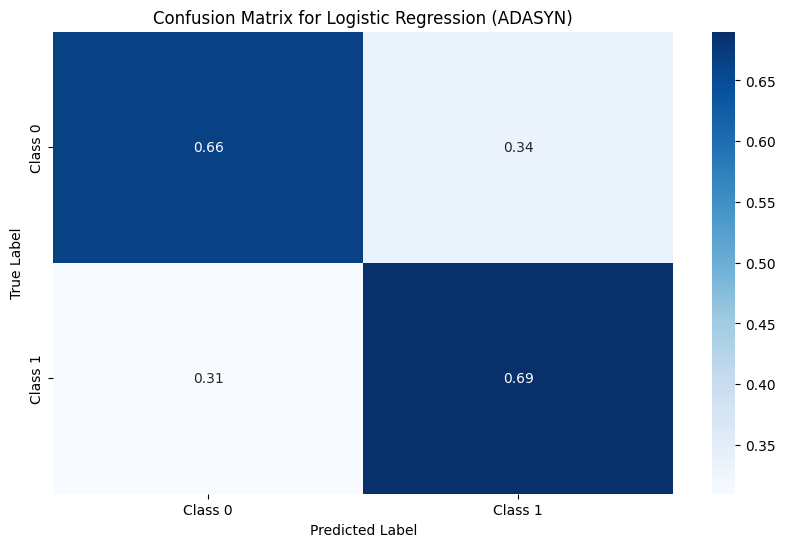

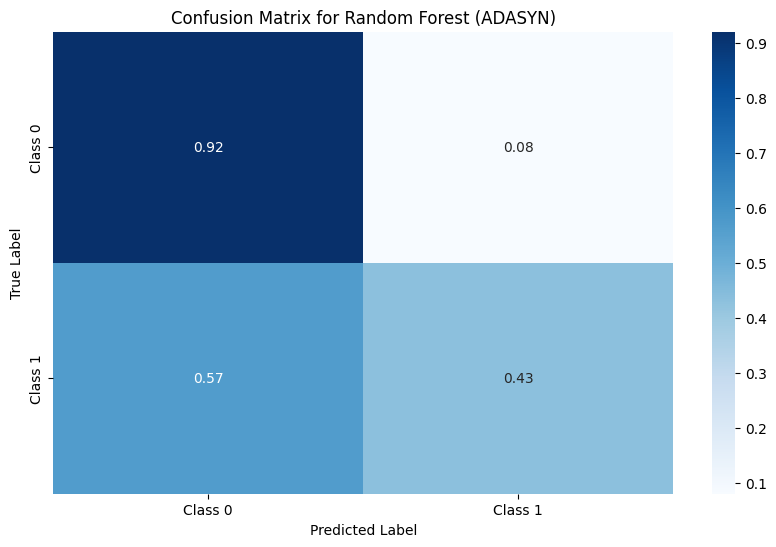

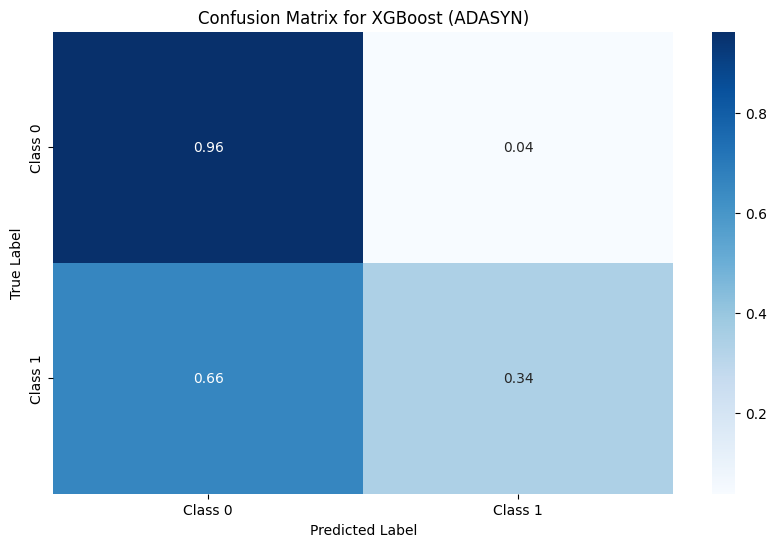

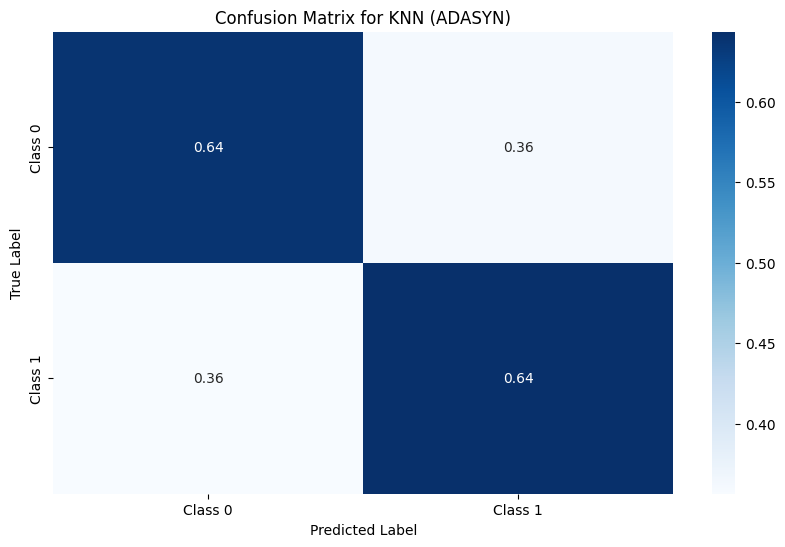

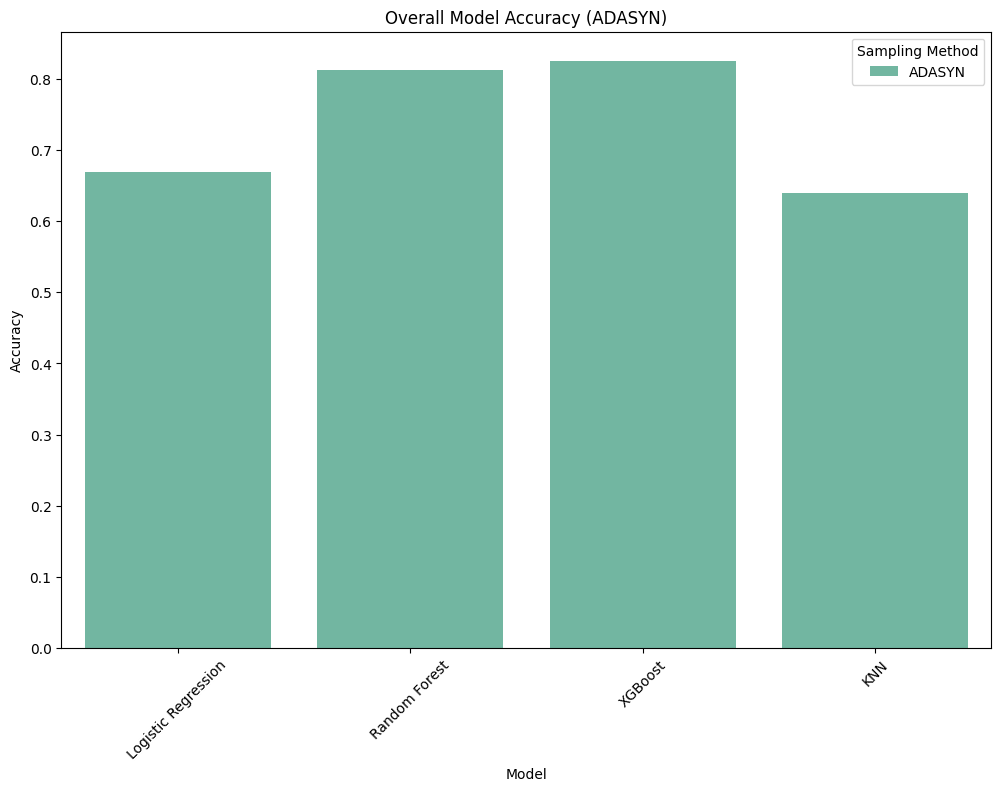

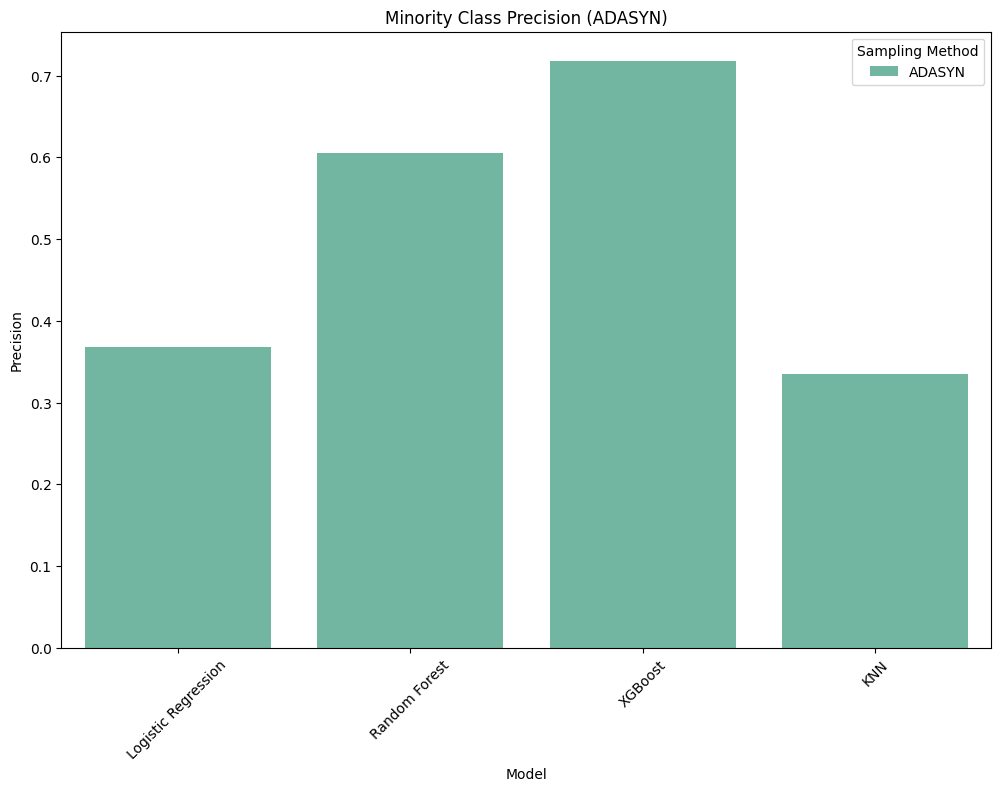

                 Model  Accuracy  Minority Precision  Minority Recall  \
0  Logistic Regression  0.669942            0.367721         0.690042   
1        Random Forest  0.812530            0.605189         0.431579   
2              XGBoost  0.825377            0.717640         0.343381   
3                  KNN  0.639807            0.335127         0.643413   

   Minority F1 Sampling Method  
0     0.479773          ADASYN  
1     0.503848          ADASYN  
2     0.464503          ADASYN  
3     0.440708          ADASYN  


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Apply ADASYN to oversample the minority class
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train_scaled, y_train)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_jobs=-1)
}

# Initialize a list to store results
results_list = []

# Evaluate each model
for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    results_list.append({
        'Model': model_name,
        'Accuracy': acc,
        'Minority Precision': report['1']['precision'],
        'Minority Recall': report['1']['recall'],
        'Minority F1': report['1']['f1-score'],
        'Sampling Method': 'ADASYN'
    })

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix for {model_name} (ADASYN)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Convert results list to DataFrame
results_adasyn = pd.DataFrame(results_list)

# Plot overall model accuracy comparison
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Accuracy', hue='Sampling Method', data=results_adasyn, palette='Set2')
plt.title('Overall Model Accuracy (ADASYN)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Plot Precision for the minority class
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Minority Precision', hue='Sampling Method', data=results_adasyn, palette='Set2')
plt.title('Minority Class Precision (ADASYN)')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Print all results for reference
print(results_adasyn)


# Random undersampling method

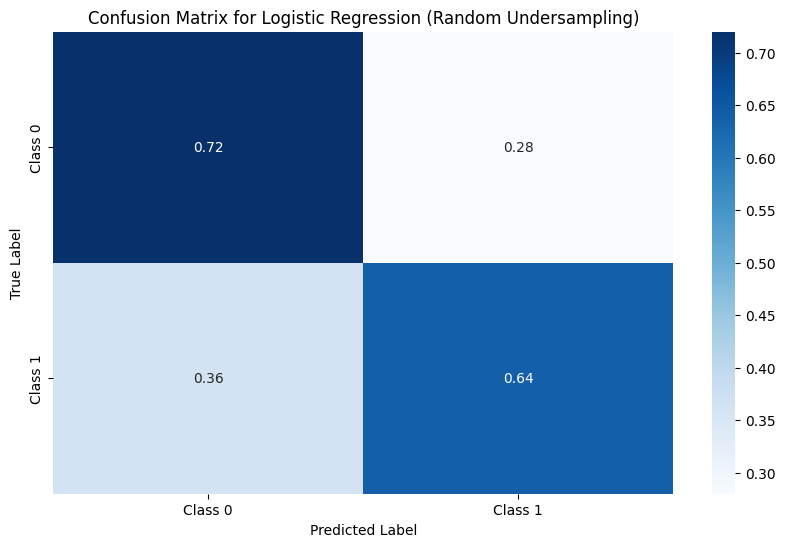

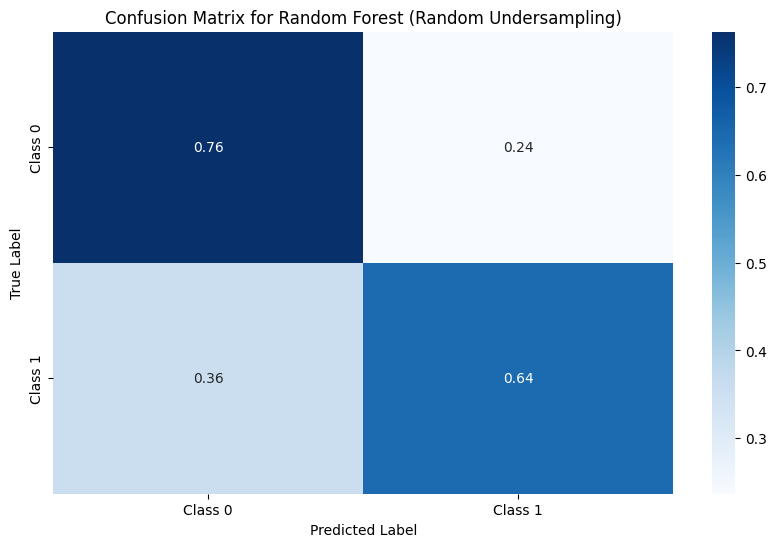

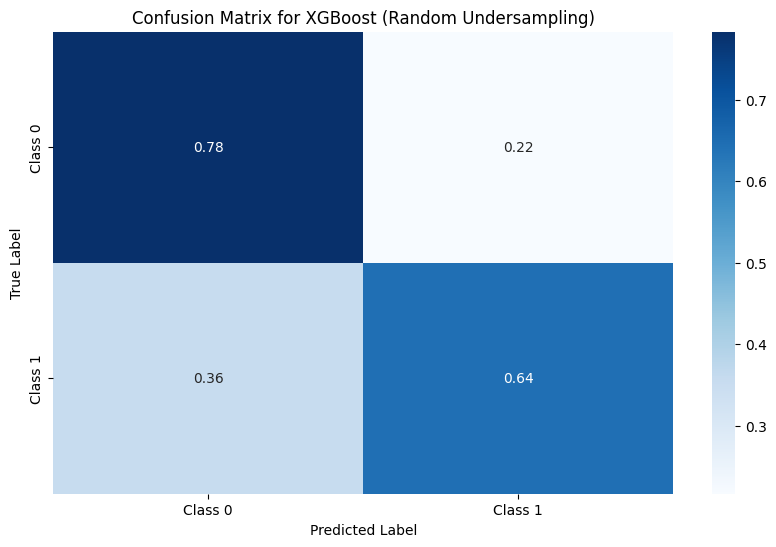

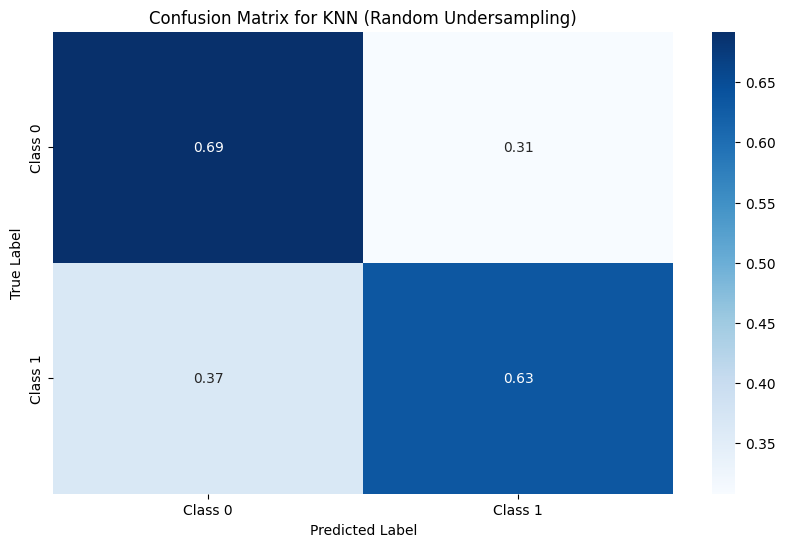

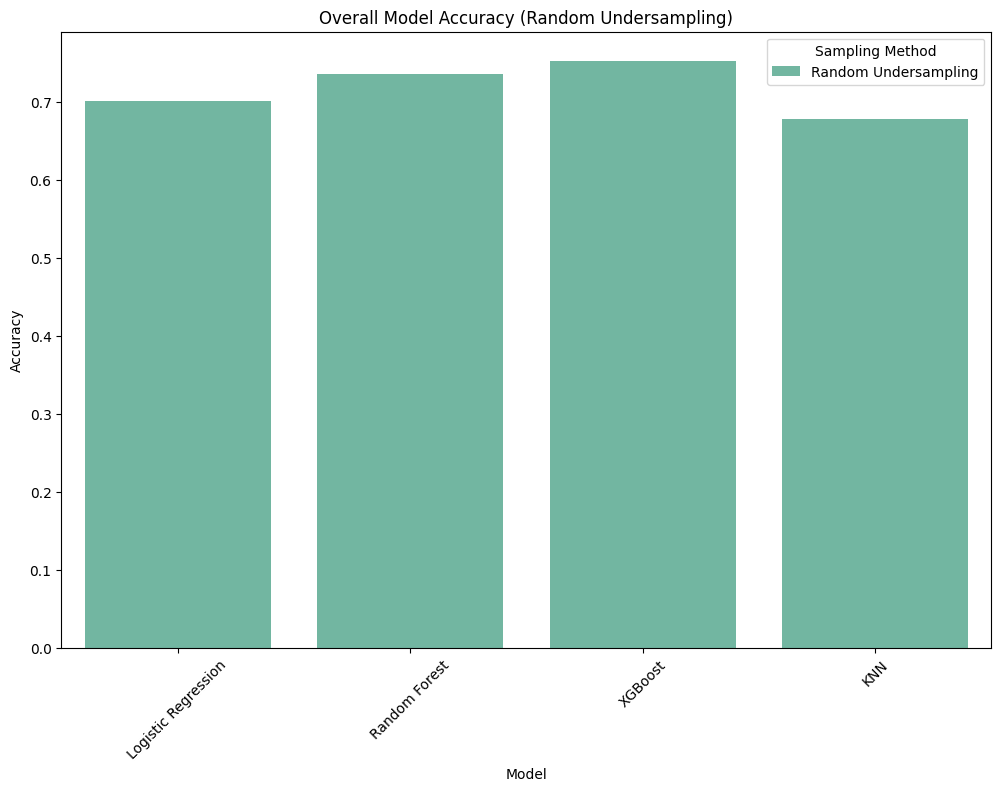

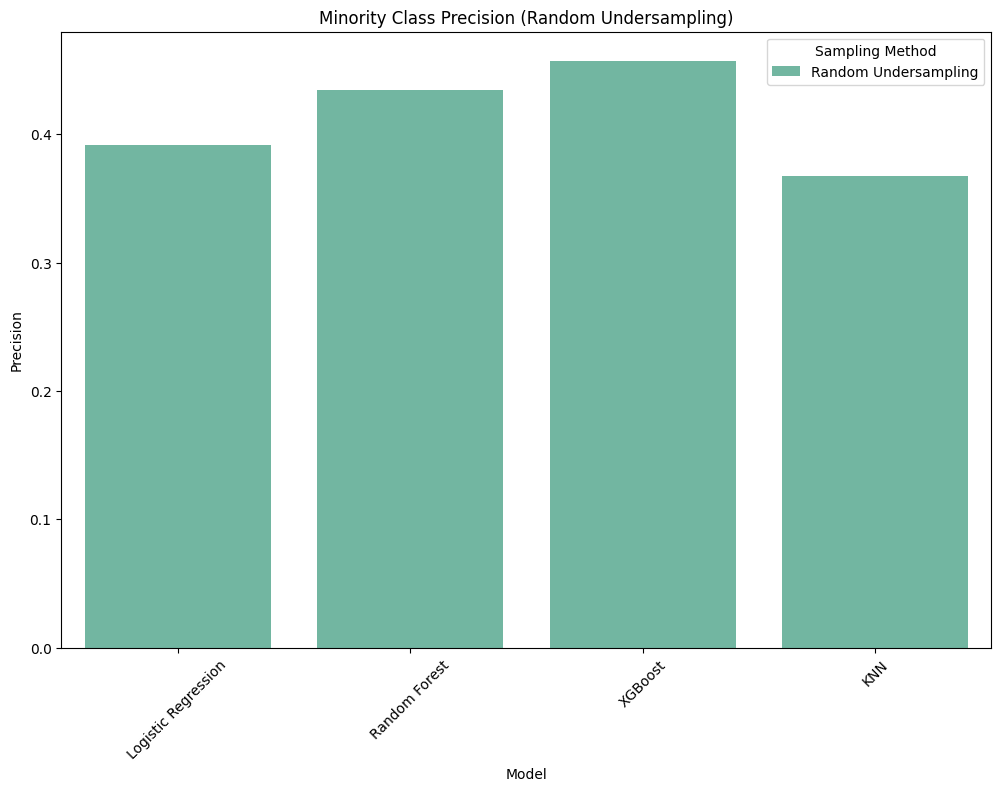

                 Model  Accuracy  Minority Precision  Minority Recall  \
0  Logistic Regression  0.701656            0.391671         0.637539   
1        Random Forest  0.736675            0.434430         0.642298   
2              XGBoost  0.752752            0.457077         0.644249   
3                  KNN  0.679077            0.367897         0.633616   

   Minority F1       Sampling Method  
0     0.485237  Random Undersampling  
1     0.518299  Random Undersampling  
2     0.534758  Random Undersampling  
3     0.465506  Random Undersampling  


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Apply Random Undersampling to the majority class
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_jobs=-1)
}

# Initialize a list to store results
results_list = []

# Evaluate each model
for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    results_list.append({
        'Model': model_name,
        'Accuracy': acc,
        'Minority Precision': report['1']['precision'],
        'Minority Recall': report['1']['recall'],
        'Minority F1': report['1']['f1-score'],
        'Sampling Method': 'Random Undersampling'
    })

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix for {model_name} (Random Undersampling)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Convert results list to DataFrame
results_undersampling = pd.DataFrame(results_list)

# Plot overall model accuracy comparison
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Accuracy', hue='Sampling Method', data=results_undersampling, palette='Set2')
plt.title('Overall Model Accuracy (Random Undersampling)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Plot Precision for the minority class
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Minority Precision', hue='Sampling Method', data=results_undersampling, palette='Set2')
plt.title('Minority Class Precision (Random Undersampling)')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Print all results for reference
print(results_undersampling)


# SMOTE Method

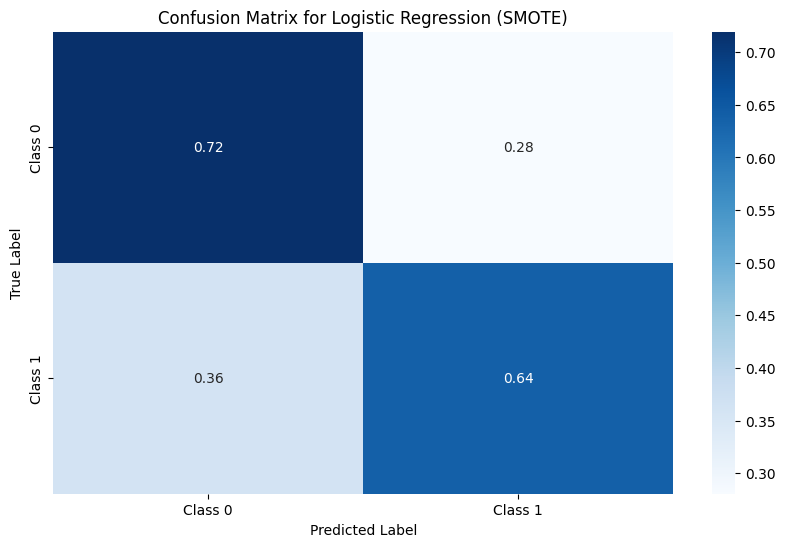

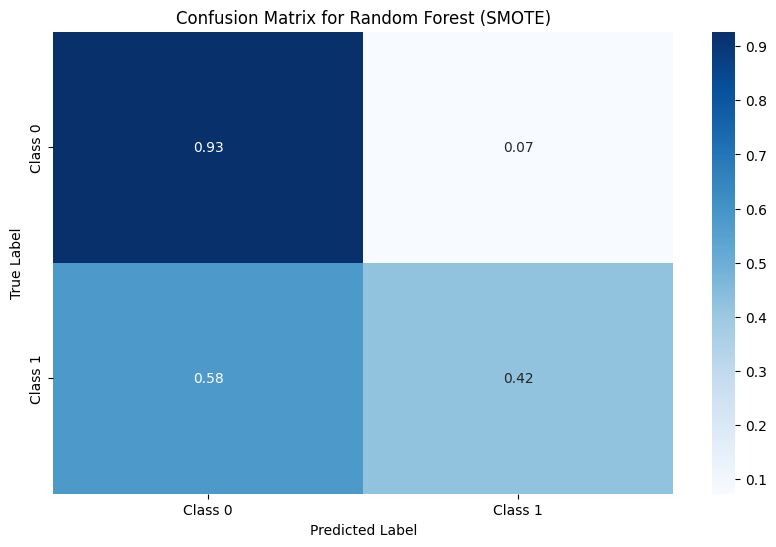

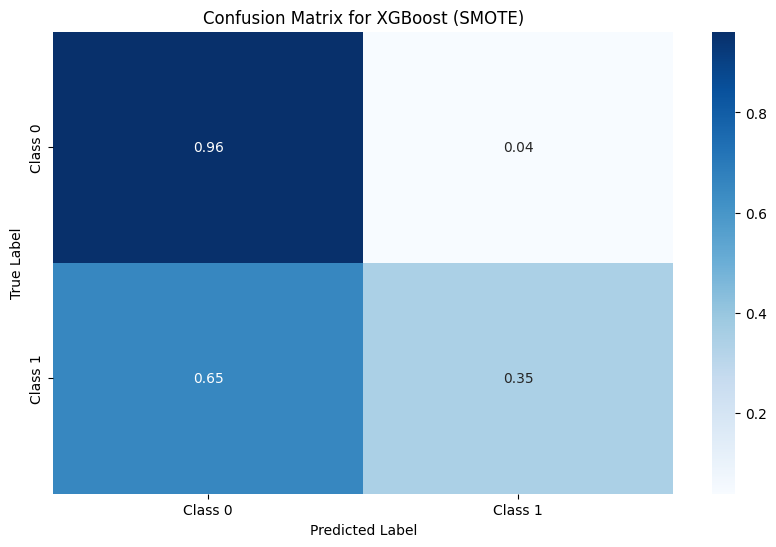

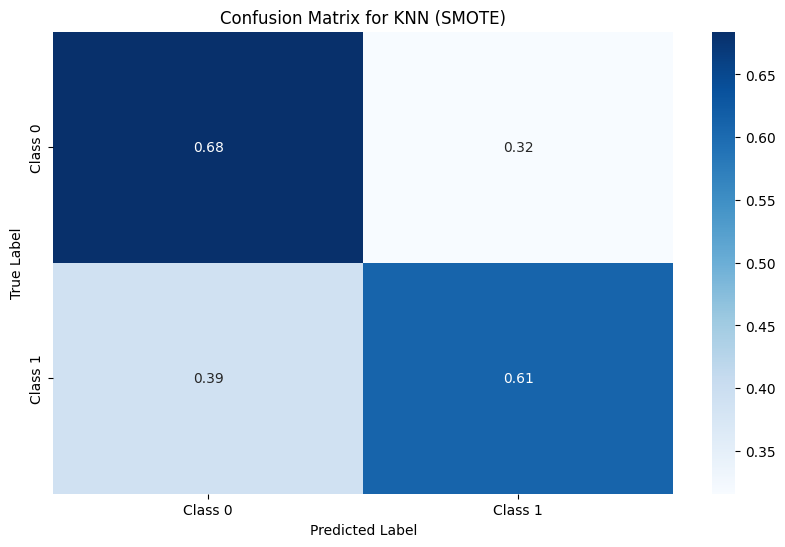

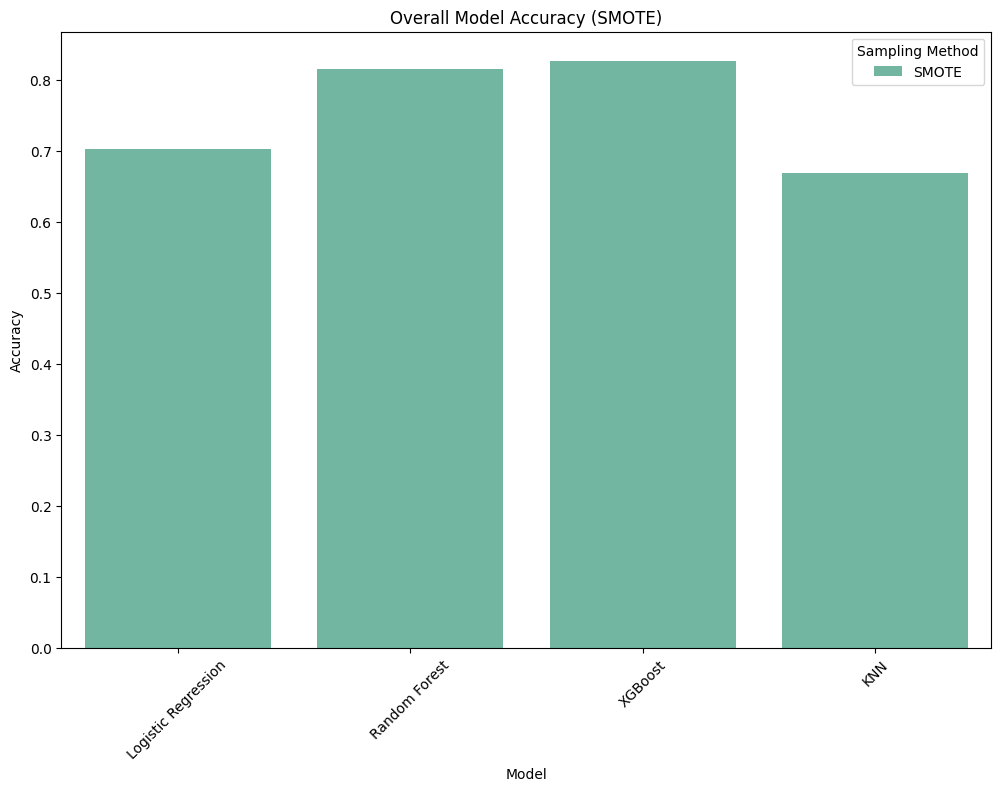

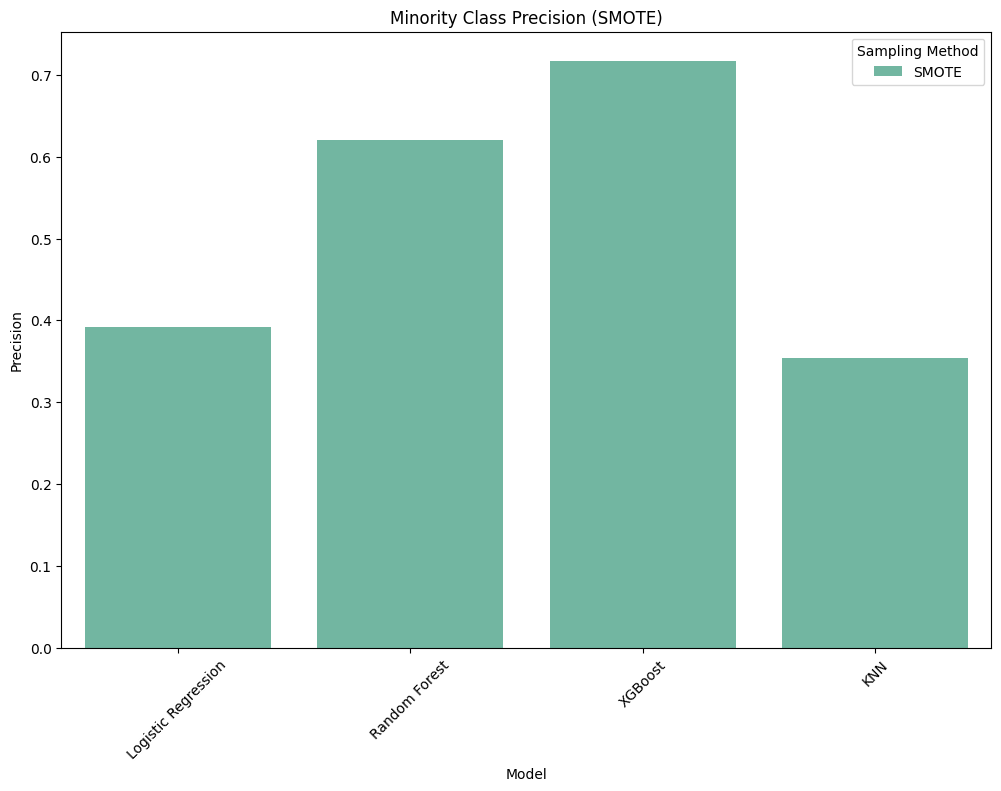

                 Model  Accuracy  Minority Precision  Minority Recall  \
0  Logistic Regression  0.701604            0.391779         0.638782   
1        Random Forest  0.815461            0.619908         0.422167   
2              XGBoost  0.825925            0.716876         0.348333   
3                  KNN  0.667824            0.353485         0.610462   

   Minority F1 Sampling Method  
0     0.485680           SMOTE  
1     0.502276           SMOTE  
2     0.468850           SMOTE  
3     0.447720           SMOTE  


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_jobs=-1)
}

# Initialize a list to store results
results_list = []

# Evaluate each model
for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    results_list.append({
        'Model': model_name,
        'Accuracy': acc,
        'Minority Precision': report['1']['precision'],
        'Minority Recall': report['1']['recall'],
        'Minority F1': report['1']['f1-score'],
        'Sampling Method': 'SMOTE'
    })

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix for {model_name} (SMOTE)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Convert results list to DataFrame
results_smote = pd.DataFrame(results_list)

# Plot overall model accuracy comparison
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Accuracy', hue='Sampling Method', data=results_smote, palette='Set2')
plt.title('Overall Model Accuracy (SMOTE)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Plot Precision for the minority class
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Minority Precision', hue='Sampling Method', data=results_smote, palette='Set2')
plt.title('Minority Class Precision (SMOTE)')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Print all results for reference
print(results_smote)


# Model Comparision using different sampling mehtods

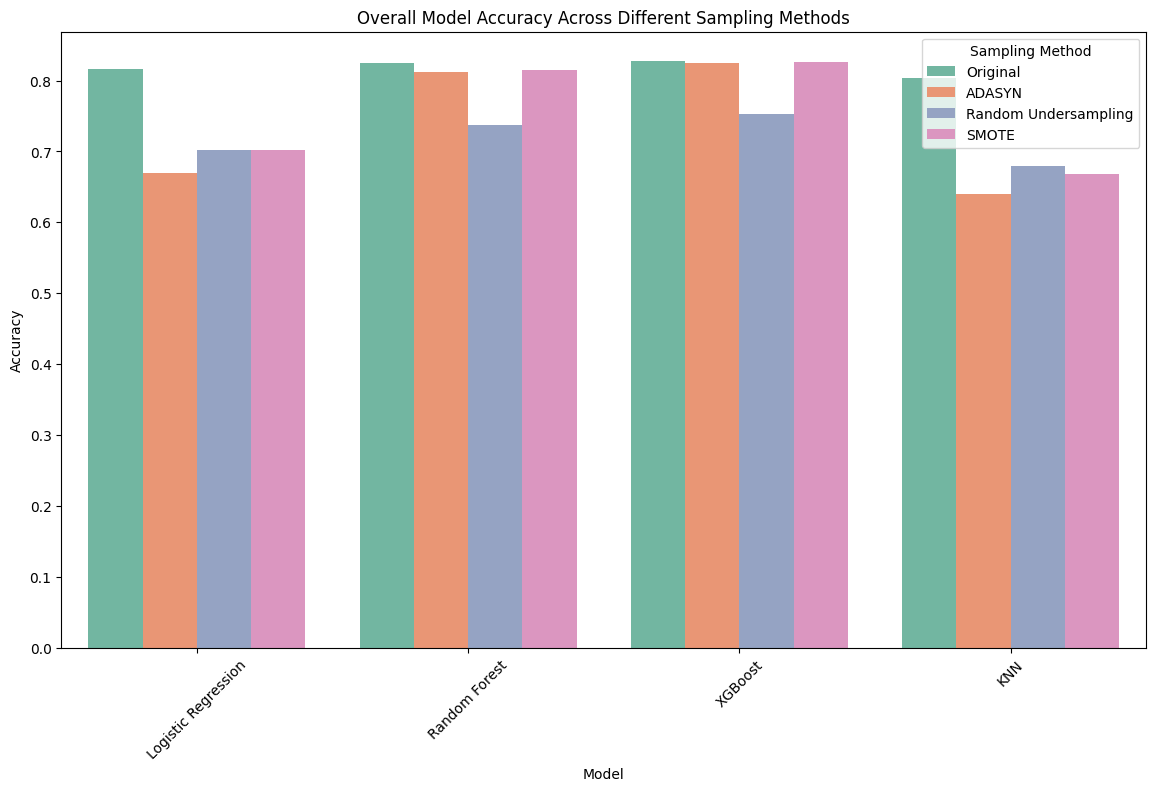

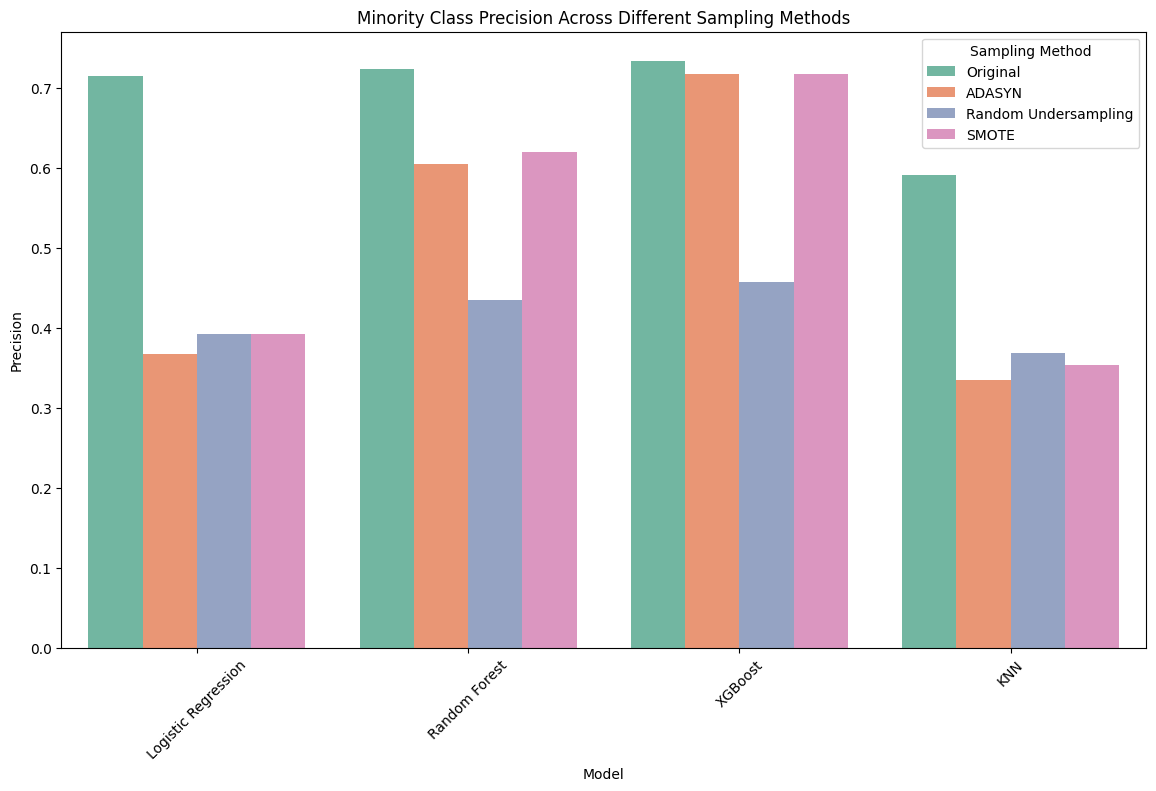

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine results from all sampling methods
all_results = pd.concat([results_original, results_adasyn, results_undersampling, results_smote])

# Plot overall model accuracy comparison across all sampling methods
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Accuracy', hue='Sampling Method', data=all_results, palette='Set2')
plt.title('Overall Model Accuracy Across Different Sampling Methods')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()

# Plot Minority Class Precision comparison across all sampling methods
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Minority Precision', hue='Sampling Method', data=all_results, palette='Set2')
plt.title('Minority Class Precision Across Different Sampling Methods')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Sampling Method', loc='best')
plt.show()


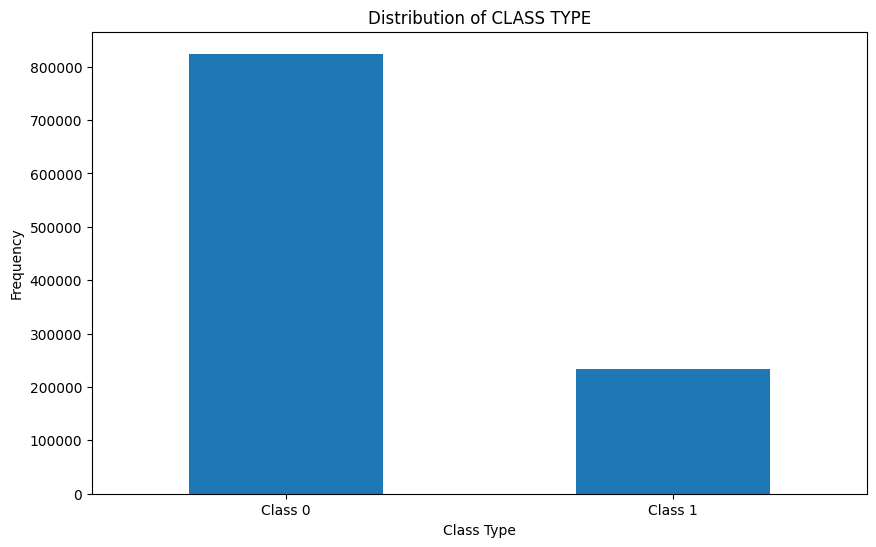

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the distribution of the 'CLASS TYPE' column
plt.figure(figsize=(10, 6))
mvc_processed['CLASS TYPE'].value_counts().plot(kind='bar')
plt.title('Distribution of CLASS TYPE')
plt.xlabel('Class Type')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()
